### Import libraries and sub-libraries

In [160]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import math
import random
import traceback
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Font setting

In [161]:
try:
    from fontsetting import font_cmu
    plt = font_cmu(plt)
except ImportError:
    print("Custom font setting 'fontsetting.py' not found. Using default fonts.")
    pass

### Configuration & Hyperparameters

In [162]:
# Data Paths
TRAIN_HIGH_RES_DIR = 'data/train/high-res'
TRAIN_LOW_RES_DIR = 'data/train/low-res'
VAL_HIGH_RES_DIR = 'data/val/high-res'
VAL_LOW_RES_DIR = 'data/val/low-res'

# Model Saving
MODEL_SAVE_PATH = 'best_unet_model.pth' # Changed model name

# Training Settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 4 # Adjusted batch size potentially needed for UNet memory
LEARNING_RATE = 1e-4 # Initial LR, scheduler will adjust
NUM_EPOCHS = 100 # Number of epochs
LOSS_ALPHA = 0.85 # Initial weight for (1-SSIM) component in loss, tune this (closer to 1 emphasizes SSIM)
LOSS_BETA = 0.15  # Initial weight for L1/MSE component (1 - LOSS_ALPHA)

# --- UNet Specific ---
UNET_DEPTH = 3 # Number of down/up stages in UNet
UNET_START_FILTERS = 64 # Number of filters in the first layer

# --- LR Scheduler Settings ---
SCHEDULER_FACTOR = 0.1 # Factor by which the learning rate will be reduced
SCHEDULER_PATIENCE = 10 # Increased patience for potentially slower UNet convergence
SCHEDULER_THRESHOLD = 1e-4 # Threshold for measuring the new optimum, to only focus on significant changes
SCHEDULER_MIN_LR = 1e-7 # Lower bound on the learning rate

# --- Experiment Tracking ---
TENSORBOARD_LOG_DIR = "runs/unet_sr_experiment" # Base directory for TensorBoard logs

# --- Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # May add these for further determinism, but can impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f'Device available: {DEVICE}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Initial Learning Rate: {LEARNING_RATE}')
print(f'Number of Epochs: {NUM_EPOCHS}')
print(f'Loss Alpha (Weight for 1-SSIM): {LOSS_ALPHA}')
print(f'Loss Beta (Weight for Pixel Loss): {1-LOSS_ALPHA}') # Calculated beta
print(f"UNet Depth: {UNET_DEPTH}")
print(f"UNet Start Filters: {UNET_START_FILTERS}")
print(f"TensorBoard Log Directory: {TENSORBOARD_LOG_DIR}")

Device available: cuda
Batch Size: 4
Initial Learning Rate: 0.0001
Number of Epochs: 100
Loss Alpha (Weight for 1-SSIM): 0.85
Loss Beta (Weight for Pixel Loss): 0.15000000000000002
UNet Depth: 3
UNet Start Filters: 64
TensorBoard Log Directory: runs/unet_sr_experiment


### Data Loading and Transformations

In [163]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, mode='train'):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.mode = mode # Store the mode (train/val)

        # Validate mode
        if self.mode not in ['train', 'val']:
            raise ValueError("Mode must be 'train' or 'val'")

        try:
            self.high_res_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
            self.low_res_filenames = sorted([f for f in os.listdir(low_res_dir) if f.endswith('.tif')])
        except FileNotFoundError as e:
            print(f"Error: Directory not found - {e}. Please check data paths.")
            raise

        if len(self.high_res_filenames) != len(self.low_res_filenames):
            raise ValueError("Mismatch in number of high-res and low-res files.")
        if not all(hr.replace('high','').replace('low','') == lr.replace('high','').replace('low','') for hr, lr in zip(self.high_res_filenames, self.low_res_filenames)):
             print("Warning: File names in high-res and low-res directories do not perfectly match (ignoring 'high'/'low' prefix). Assuming correspondence by sorted order.")

        self.filenames = self.high_res_filenames # Use high-res list as reference

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        high_res_filename = self.filenames[idx]
        low_res_filename = self.low_res_filenames[idx]

        high_res_path = os.path.join(self.high_res_dir, high_res_filename)
        low_res_path = os.path.join(self.low_res_dir, low_res_filename)

        try:
            # 1. Load images using PIL (WITHOUT .convert('L'))
            high_res_img_pil = Image.open(high_res_path)
            low_res_img_pil = Image.open(low_res_path)

            # 2. Check sizes (Resizing should handle mode 'F' correctly)
            target_high_res_size = (256, 256) # H, W
            target_low_res_size = (128, 128) # H, W
            if high_res_img_pil.size != target_high_res_size[::-1]:
                 high_res_img_pil = high_res_img_pil.resize(target_high_res_size[::-1], Image.BICUBIC)
            if low_res_img_pil.size != target_low_res_size[::-1]:
                 low_res_img_pil = low_res_img_pil.resize(target_low_res_size[::-1], Image.BICUBIC)

            # 3. Convert PIL images to Tensors
            # TF.to_tensor handles mode 'F' directly (no scaling)
            # and other modes like 'L' (scales 0-255 to 0-1)
            # Add check: if not mode F, convert to L first (safer fallback)
            if high_res_img_pil.mode != 'F':
                 high_res_img_pil = high_res_img_pil.convert('L')
            if low_res_img_pil.mode != 'F':
                 low_res_img_pil = low_res_img_pil.convert('L')

            low_res_tensor = TF.to_tensor(low_res_img_pil)
            high_res_tensor = TF.to_tensor(high_res_img_pil)

            # 4. Apply Geometric Augmentations ONLY if mode is 'train'
            if self.mode == 'train':
                # Random Horizontal Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.hflip(low_res_tensor)
                    high_res_tensor = TF.hflip(high_res_tensor)

                # Random Vertical Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.vflip(low_res_tensor)
                    high_res_tensor = TF.vflip(high_res_tensor)

                # Random 90-degree Rotations
                k = random.choice([0, 1, 2, 3]) # 0=0deg, 1=90deg, 2=180deg, 3=270deg
                if k > 0:
                     # torch.rot90 expects (..., H, W)
                     low_res_tensor = torch.rot90(low_res_tensor, k=k, dims=(-2, -1))
                     high_res_tensor = torch.rot90(high_res_tensor, k=k, dims=(-2, -1))

        except FileNotFoundError:
            print(f"Error: File not found for index {idx}. Paths: {high_res_path}, {low_res_path}")
            return None, None
        except Exception as e:
            print(f"Error loading/transforming image at index {idx}: {e}")
            traceback.print_exc()
            return None, None

        # low_res_tensor shape: [1, 128, 128], high_res_tensor shape: [1, 256, 256]
        return low_res_tensor, high_res_tensor

# Datasets with mode setting
try:
    train_dataset = TIFFDataset(
        high_res_dir=TRAIN_HIGH_RES_DIR,
        low_res_dir=TRAIN_LOW_RES_DIR,
        mode='train'
    )
    val_dataset = TIFFDataset(
        high_res_dir=VAL_HIGH_RES_DIR,
        low_res_dir=VAL_LOW_RES_DIR,
        mode='val'
    )
except Exception as e:
     print(f"Failed to create datasets: {e}")
     exit()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')


Number of training images: 240
Number of validation images: 30


### Evaluation Metrics Implementation

In [164]:
# Manual PSNR calculation (assuming max pixel value of 1.0 for normalized data)
def psnr(target, output, max_val=1.0):
    # Ensure target and output are tensors
    if not isinstance(target, torch.Tensor): target = torch.tensor(target)
    if not isinstance(output, torch.Tensor): output = torch.tensor(output)

    # Clamp output to valid range [0, 1] before calculating MSE
    output = torch.clamp(output, 0.0, max_val)

    mse = F.mse_loss(output, target)
    if mse == 0:
        return torch.tensor(float('inf')) # Return tensor for consistency if needed later
    # Ensure positive value inside sqrt before log
    if mse < 0: # Should not happen with mse_loss, but safety check
        print("Warning: Negative MSE encountered in PSNR calculation.")
        return torch.tensor(0.0)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

# SSIM metric using torchmetrics
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE) # data_range=1.0 for normalized images

# Combined Score Calculation
def calculate_score(psnr_val, ssim_val):
    # Ensure inputs are numbers
    if isinstance(psnr_val, torch.Tensor): psnr_val = psnr_val.item()
    if isinstance(ssim_val, torch.Tensor): ssim_val = ssim_val.item()
    # Handle potential inf PSNR
    if psnr_val == float('inf'):
        # If PSNR is infinite (perfect reconstruction), SSIM should also be 1.
        # Assign a very high score, or decide how to handle perfect cases.
        return float('inf') # Or a large finite number if needed for sorting/comparison
    # Ensure ssim_val is valid
    if not (0 <= ssim_val <= 1):
        print(f"Warning: SSIM value {ssim_val} out of range [0, 1]. Clamping.")
        ssim_val = max(0.0, min(1.0, ssim_val)) # Clamp SSIM just in case
    return psnr_val + 40 * ssim_val

# Helper to calculate metrics for a batch
def calculate_metrics(output, target):
    output = output.detach().to(DEVICE)
    target = target.detach().to(DEVICE)
    output_clamped = torch.clamp(output, 0.0, 1.0) # Clamp here for metric calculation consistency

    # Calculate PSNR per image in batch and average
    batch_psnr = 0.0
    valid_psnr_count = 0
    inf_psnr_count = 0
    for i in range(output.shape[0]):
        psnr_val = psnr(target[i], output_clamped[i])
        if psnr_val == float('inf'):
            inf_psnr_count += 1
        else:
            batch_psnr += psnr_val.item()
            valid_psnr_count += 1

    if valid_psnr_count > 0:
        avg_psnr = batch_psnr / valid_psnr_count
    elif inf_psnr_count > 0: # Only inf values encountered
        avg_psnr = float('inf')
    else: # Should not happen if batch size > 0
        avg_psnr = 0.0

    # Ensure batch dim exists for SSIM (should have 4 dims: B, C, H, W)
    if output_clamped.dim() != 4:
        print(f"Warning: Output dimensions for SSIM are incorrect: {output_clamped.shape}. Attempting reshape.")
        # Handle potential issues, e.g., if channel dim is missing
        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(1) # Add channel dim
        if target.dim() == 3: target = target.unsqueeze(1)

    # Check if dimensions are still wrong before calling SSIM
    if output_clamped.dim() != 4 or target.dim() != 4 or output_clamped.shape[1] != 1 or target.shape[1] != 1:
         print(f"Error: Cannot compute SSIM. Invalid shapes. Output: {output_clamped.shape}, Target: {target.shape}")
         avg_ssim = 0.0 # Return default bad value
    else:
        try:
            avg_ssim = ssim_metric(output_clamped, target).item()
        except Exception as e:
            print(f"Error computing SSIM: {e}. Output: {output_clamped.shape}, Target: {target.shape}")
            avg_ssim = 0.0 # Default bad value on error

    score = calculate_score(avg_psnr, avg_ssim)
    return avg_psnr, avg_ssim, score

### Super-Resolution Network Definition (U-Net)

In [165]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), # Using BatchNorm, adjust if needed
            nn.GELU(),
            # nn.LeakyReLU(0.2, inplace=True), # Alternative activation
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
            # nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            # Note: Bilinear might not be ideal for SR compared to TransposedConv/PixelShuffle
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # Using Transposed Convolution for learned upsampling
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels) # in_channels = skip features + upsampled features

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False, depth=3, start_filters=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.depth = depth
        factor = 2 if bilinear else 1
        upscale_factor = 2 # Final upscale factor needed

        self.inc = DoubleConv(n_channels, start_filters)
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()

        # Encoder path
        in_ch = start_filters
        for i in range(depth):
            out_ch = in_ch * 2
            self.down_layers.append(Down(in_ch, out_ch))
            in_ch = out_ch

        # Bottleneck (implicitly the output of the last down layer)

        # Decoder path
        for i in range(depth):
            out_ch = in_ch // 2
            # The input channels for Up module are in_ch (from below) + out_ch (from skip connection)
            self.up_layers.append(Up(in_ch, out_ch // factor, bilinear))
            in_ch = out_ch

        # Convolution before final PixelShuffle
        self.conv_before_shuffle = nn.Conv2d(start_filters, n_classes * (upscale_factor ** 2), kernel_size=3, padding=1)

        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale_factor)

        print(f"UNet initialized with depth={depth}, start_filters={start_filters}, bilinear={bilinear}, final_upsample='PixelShuffle'")

    def forward(self, x):
        # Expects input x: [B, 1, 128, 128]
        skip_connections = []

        # Encoder
        x = self.inc(x) # Size: [B, start_filters, 128, 128]
        skip_connections.append(x)
        for i, down_layer in enumerate(self.down_layers):
            x = down_layer(x)
            if i < self.depth - 1: # Store skip connections except for bottleneck output
                 skip_connections.append(x)

        # Decoder
        skip_connections = skip_connections[::-1] # Reverse skip connections list

        for i, up_layer in enumerate(self.up_layers):
            skip = skip_connections[i]
            x = up_layer(x, skip)
            # After decoder, x has shape [B, start_filters, 128, 128]

        # Apply convolution before shuffle
        x = self.conv_before_shuffle(x) # Shape: [B, n_classes * upscale^2, 128, 128] = [B, 4, 128, 128]

        # Apply PixelShuffle
        output = self.pixel_shuffle(x) # Shape: [B, n_classes, 128*upscale, 128*upscale] = [B, 1, 256, 256]

        return output

### Loss Function Definition

In [166]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.85, data_range=1.0): # alpha weights SSIM loss
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = 1.0 - alpha # Weight for pixel loss
        self.pixel_loss = nn.L1Loss()
        self.ssim_loss_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(DEVICE)
        print(f"CombinedLoss initialized with alpha={alpha} (weight for 1-SSIM loss), beta={self.beta} (weight for Pixel loss)")
        print(f"Using {type(self.pixel_loss).__name__} for pixel loss.")

    def forward(self, output, target):
        output_clamped = torch.clamp(output, 0.0, 1.0) # Clamp for SSIM calculation consistency
        pixel_loss_val = self.pixel_loss(output, target) # Use raw output for pixel loss

        # Ensure inputs have B, C, H, W dimensions for SSIM
        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(1)
        if target.dim() == 3: target = target.unsqueeze(1)
        if output_clamped.dim() != 4 or target.dim() != 4 or output_clamped.shape[1] != 1 or target.shape[1] != 1:
             print(f"Error: Cannot compute SSIM loss. Invalid shapes. Output: {output_clamped.shape}, Target: {target.shape}")
             ssim_loss = torch.tensor(1.0).to(DEVICE) # Penalize heavily if shape is wrong
        else:
            try:
                # Ensure SSIM inputs are on the correct device
                 ssim_val = self.ssim_loss_metric(output_clamped.to(DEVICE), target.to(DEVICE))
                 ssim_loss = 1.0 - ssim_val
            except Exception as e:
                print(f"Error computing SSIM for loss: {e}. Output: {output_clamped.shape}, Target: {target.shape}")
                ssim_loss = torch.tensor(1.0).to(DEVICE) # Penalize heavily on error

        combined_loss = self.beta * pixel_loss_val + self.alpha * ssim_loss
        return combined_loss

### Training and Validation Functions

In [167]:
# Function for one training epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    processed_batches = 0
    for i, batch in enumerate(loader):
        # Simple check if batch is None or invalid
        if batch is None or len(batch) != 2:
            print(f"Skipping batch {i} due to invalid data.")
            continue
        low_res_batch, high_res_batch = batch

        if low_res_batch is None or high_res_batch is None:
             print(f"Skipping batch {i} due to loading error within batch.")
             continue

        low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)
        # Input: low_res_batch [B, 1, 128, 128]
        # Target: high_res_batch [B, 1, 256, 256]

        optimizer.zero_grad()
        super_res_batch = model(low_res_batch) # UNet handles upsampling
        loss = criterion(super_res_batch, high_res_batch)

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"Warning: NaN loss encountered in training batch {i}. Skipping update.")
            # Potentially add more debugging here: print inputs/outputs/gradients
            continue

        loss.backward()
        # Optional: Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        processed_batches += 1

    if processed_batches == 0: return 0.0
    avg_loss = total_loss / processed_batches
    return avg_loss


# Function for validation
def validate_model(model, loader, criterion):
    model.eval()
    total_val_loss = 0
    total_psnr = 0
    total_ssim = 0
    total_score = 0
    num_samples = 0 # Use number of samples for accurate averaging
    inf_score_count = 0 # Count batches with infinite score

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if batch is None or len(batch) != 2:
                print(f"Skipping validation batch {i} due to invalid data.")
                continue
            low_res_batch, high_res_batch = batch

            if low_res_batch is None or high_res_batch is None:
                 print(f"Skipping validation batch {i} due to loading error within batch.")
                 continue

            batch_size = low_res_batch.size(0) # Get current batch size
            low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)
            # Input: low_res_batch [B, 1, 128, 128]
            # Target: high_res_batch [B, 1, 256, 256]

            super_res_batch = model(low_res_batch) # UNet handles upsampling

            loss = criterion(super_res_batch, high_res_batch)
             # Check for NaN loss during validation
            if torch.isnan(loss):
                print(f"Warning: NaN loss encountered in validation batch {i}.")
                val_loss_item = 0 # Or handle as appropriate
            else:
                val_loss_item = loss.item()

            total_val_loss += val_loss_item * batch_size # Weight loss by batch size

            batch_psnr, batch_ssim, batch_score = calculate_metrics(super_res_batch, high_res_batch)

            # Handle potential inf score
            if batch_score == float('inf'):
                 # If score is inf, psnr must be inf. Add counts but exclude from avg calculation
                 # unless ALL scores are inf.
                 inf_score_count += batch_size
                 num_samples += batch_size # Still count the sample
                 # Decide how to treat inf PSNR/Score in averages, e.g., report separately or assign large value
            elif not (math.isnan(batch_psnr) or math.isnan(batch_ssim) or math.isnan(batch_score)):
                 total_psnr += batch_psnr * batch_size
                 total_ssim += batch_ssim * batch_size
                 total_score += batch_score * batch_size
                 num_samples += batch_size
            else:
                 print(f"Warning: NaN metric encountered in validation batch {i}. PSNR={batch_psnr}, SSIM={batch_ssim}, Score={batch_score}")


    if num_samples == 0: return 0.0, 0.0, 0.0, 0.0 # No valid samples processed

    # Calculate averages, handling cases with only infinite scores
    avg_val_loss = total_val_loss / num_samples if num_samples > 0 else 0.0

    valid_metric_samples = num_samples - inf_score_count
    if valid_metric_samples > 0:
        avg_psnr = total_psnr / valid_metric_samples
        avg_ssim = total_ssim / valid_metric_samples
        avg_score = total_score / valid_metric_samples
    elif inf_score_count > 0 and num_samples == inf_score_count: # All scores were infinite
        avg_psnr = float('inf')
        avg_ssim = 1.0 # SSIM is 1 if PSNR is inf
        avg_score = float('inf')
    else: # No valid samples at all
        avg_psnr = 0.0
        avg_ssim = 0.0
        avg_score = 0.0

    return avg_val_loss, avg_psnr, avg_ssim, avg_score


# Main training loop function (with TensorBoard and LR Scheduler)
def train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, model_save_path, writer):
    train_losses = []
    val_losses = []
    val_scores = []
    best_val_score = -float('inf') # Initialize to negative infinity

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        current_lr = optimizer.param_groups[0]['lr']
        print(f'  Learning Rate: {current_lr:.2e}')

        # Training phase
        avg_train_loss = train_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        print(f'  Average Training Loss: {avg_train_loss:.6f}')
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation phase
        avg_val_loss, avg_psnr, avg_ssim, avg_score = validate_model(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_scores.append(avg_score) # Store numeric score, handle 'inf' case below if needed
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        print(f'  Validation PSNR: {avg_psnr:.2f} dB' if avg_psnr != float('inf') else '  Validation PSNR: inf dB')
        print(f'  Validation SSIM: {avg_ssim:.4f}')
        print(f'  Validation Score (PSNR + 40*SSIM): {avg_score:.4f}' if avg_score != float('inf') else '  Validation Score: inf')

        # Log validation metrics to TensorBoard
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        # Handle inf PSNR/Score for logging - log a large number or skip?
        writer.add_scalar('Metrics/val_PSNR', avg_psnr if avg_psnr != float('inf') else 100, epoch) # Log 100 for inf PSNR
        writer.add_scalar('Metrics/val_SSIM', avg_ssim, epoch)
        writer.add_scalar('Metrics/val_Score', avg_score if avg_score != float('inf') else 100 + 40*1, epoch) # Log large score for inf
        writer.add_scalar('LearningRate', current_lr, epoch)

        # LR Scheduler Step (based on validation score)
        # Need finite value for scheduler; treat 'inf' as the best possible score.
        scheduler_metric = avg_score if avg_score != float('inf') else best_val_score + 1 # Treat inf as improvement
        scheduler.step(scheduler_metric)

        # Save model if validation score improves
        # Handle 'inf' score properly: an 'inf' score is always better than a finite one.
        # A new finite score is better than the previous best finite score.
        save_model = False
        if avg_score == float('inf') and best_val_score != float('inf'):
            save_model = True # First time hitting infinite score
            print("  ** Achieved infinite validation score! **")
        elif avg_score != float('inf'):
             if best_val_score == float('inf'):
                 pass # Don't replace infinite score model with finite one
             elif avg_score > best_val_score:
                 save_model = True

        if save_model:
            best_val_score = avg_score # Update best score (can be inf)
            torch.save(model.state_dict(), model_save_path)
            print(f'  ** New best validation score! Model saved to {model_save_path} **')

    print("\n--- Training Complete ---")
    print(f"Best Validation Score achieved: {best_val_score:.4f}" if best_val_score != float('inf') else "Best Validation Score achieved: inf")
    writer.close() # Close the TensorBoard writer

    # Plotting (remains the same, might need adjustment for inf values if they occur)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color=color, linestyle='--')
    ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
    try:
        # Use symlog if losses get very small or cover large range
        ax1.set_yscale('symlog', linthresh=1e-5)
    except ValueError:
        print("Warning: Could not set symlog scale for loss. Using linear scale.")
        ax1.set_yscale('linear')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Score (PSNR + 40*SSIM)', color=color)
    # Filter out potential 'inf' for plotting or handle appropriately
    plot_scores = [s if s != float('inf') else np.nan for s in val_scores] # Replace inf with NaN for plotting
    ax2.plot(range(1, num_epochs + 1), plot_scores, label='Validation Score', color=color, marker='o', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    if any(s == float('inf') for s in val_scores):
         ax2.text(0.95, 0.95, 'Note: inf scores not plotted', transform=ax2.transAxes, ha='right', va='top', color=color, fontsize=9)

    fig.tight_layout()
    plt.title('Training/Validation Loss and Validation Score (UNet)')
    plt.show()

### Initialize and Train the Model

TensorBoard logs will be saved to: runs/unet_sr_experiment\20250410-192725
UNet initialized with depth=3, start_filters=64, bilinear=False, final_upsample='PixelShuffle'
CombinedLoss initialized with alpha=0.85 (weight for 1-SSIM loss), beta=0.15000000000000002 (weight for Pixel loss)
Using L1Loss for pixel loss.

--- Starting Training ---

Epoch 1/100
  Learning Rate: 1.00e-04


c:\Users\Rahb\Documents\GitHub\BME5710-FinalProject\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Average Training Loss: 0.520769
  Validation Loss: 0.313616
  Validation PSNR: 23.65 dB
  Validation SSIM: 0.6467
  Validation Score (PSNR + 40*SSIM): 49.5144
  ** New best validation score! Model saved to best_unet_model.pth **

Epoch 2/100
  Learning Rate: 1.00e-04
  Average Training Loss: 0.290164
  Validation Loss: 0.252871
  Validation PSNR: 23.46 dB
  Validation SSIM: 0.7164
  Validation Score (PSNR + 40*SSIM): 52.1127
  ** New best validation score! Model saved to best_unet_model.pth **

Epoch 3/100
  Learning Rate: 1.00e-04
  Average Training Loss: 0.219303
  Validation Loss: 0.217679
  Validation PSNR: 23.82 dB
  Validation SSIM: 0.7545
  Validation Score (PSNR + 40*SSIM): 54.0040
  ** New best validation score! Model saved to best_unet_model.pth **

Epoch 4/100
  Learning Rate: 1.00e-04
  Average Training Loss: 0.170643
  Validation Loss: 0.143779
  Validation PSNR: 26.56 dB
  Validation SSIM: 0.8365
  Validation Score (PSNR + 40*SSIM): 60.0192
  ** New best validation scor

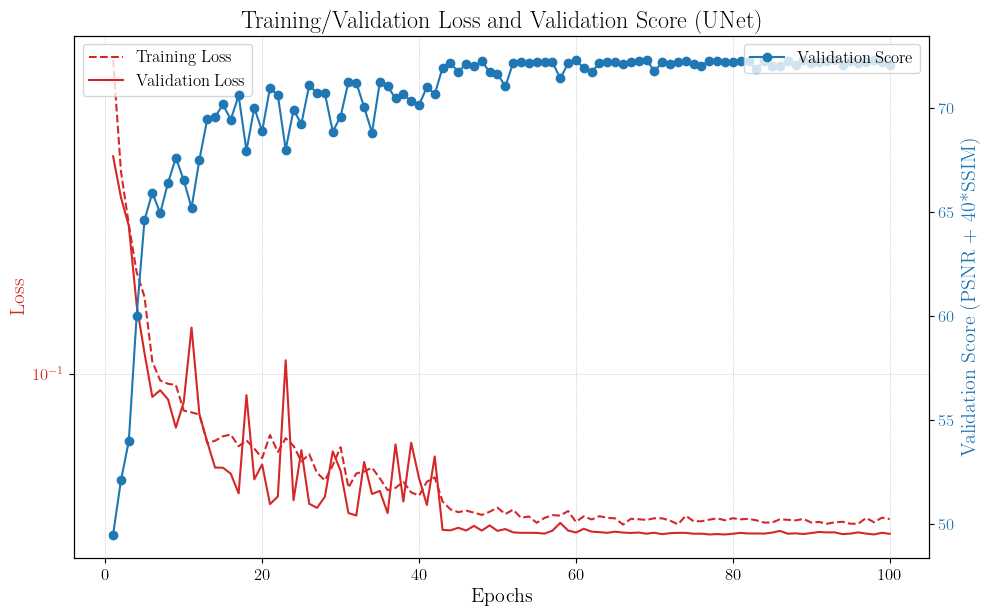

In [168]:
# TensorBoard Writer Setup
log_subdir = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOG_DIR, log_subdir))
print(f"TensorBoard logs will be saved to: {os.path.join(TENSORBOARD_LOG_DIR, log_subdir)}")

# Model Initialization (Using UNet)
model = UNet(n_channels=1,
             n_classes=1,
             depth=UNET_DEPTH,
             start_filters=UNET_START_FILTERS,
             bilinear=False # Use Transposed Convolutions
             ).to(DEVICE)

# Optimizer (Adam or AdamW)
# AdamW is often preferred for better weight decay handling
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Added small weight decay

# LR Scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              mode='max', # Maximize validation score
                              factor=SCHEDULER_FACTOR,
                              patience=SCHEDULER_PATIENCE,
                              threshold=SCHEDULER_THRESHOLD,
                              min_lr=SCHEDULER_MIN_LR,
                              verbose=True)

# Loss Function (Criterion)
criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE)

# Train the model
train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, NUM_EPOCHS, MODEL_SAVE_PATH, writer)


### Evaluate the Best Model on a Validation Image Example


--- Evaluating Best Model (UNet) on Example Validation Image ---
UNet initialized with depth=3, start_filters=64, bilinear=False, final_upsample='PixelShuffle'
Loaded best UNet model weights from best_unet_model.pth

Metrics for Example Image (Index 0):
  PSNR: 34.64 dB
  SSIM: 0.9698
  Score (PSNR + 40*SSIM): 73.4378


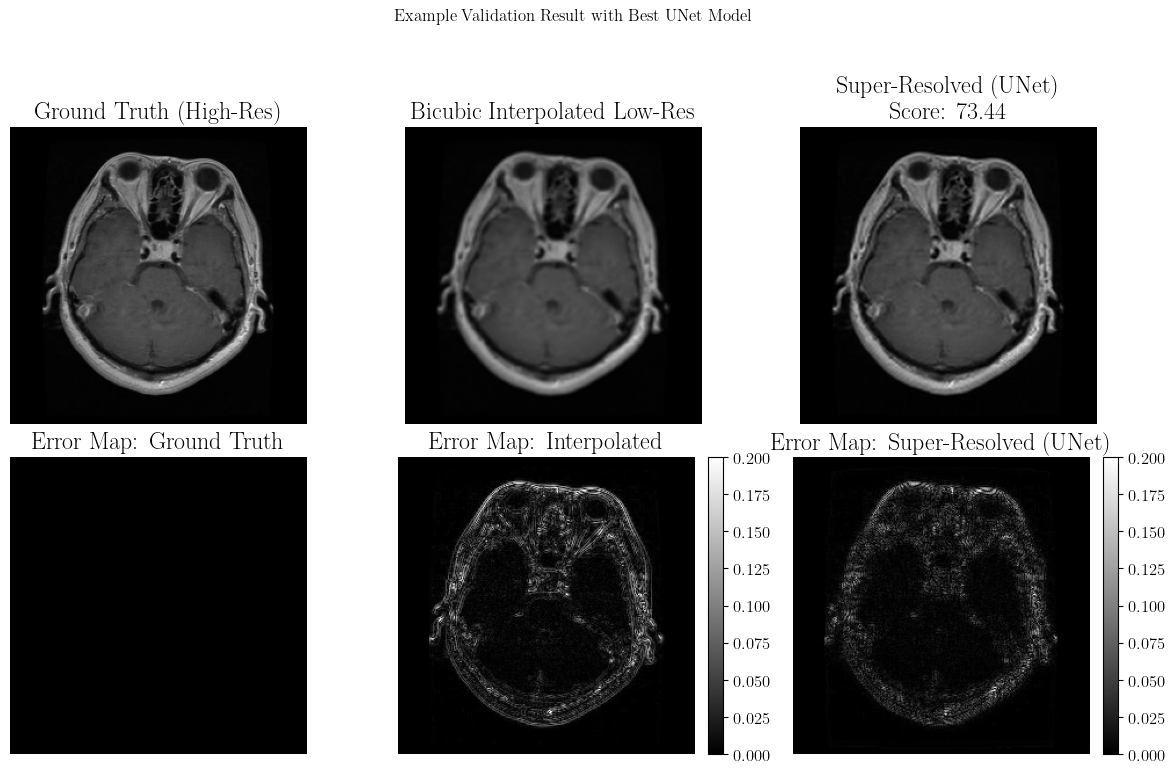

In [169]:
print("\n--- Evaluating Best Model (UNet) on Example Validation Image ---")

# Load the best model weights
best_model = UNet(n_channels=1, n_classes=1, depth=UNET_DEPTH, start_filters=UNET_START_FILTERS).to(DEVICE) # Instantiate UNet
try:
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    best_model.eval()
    print(f"Loaded best UNet model weights from {MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Best model file '{MODEL_SAVE_PATH}' not found. Skipping example evaluation.")
    best_model = model # Fallback to the last state (might not be the best)
    best_model.eval() # Ensure eval mode
except Exception as e:
     print(f"Error loading model weights: {e}. Skipping example evaluation.")
     best_model = model # Fallback
     best_model.eval()

# Load one validation image pair (using index 0 as example)
try:
    # Get sample directly using the dataset's __getitem__
    val_low_res, val_high_res = val_dataset[0]
    if val_low_res is None or val_high_res is None:
        raise ValueError("Failed to load validation sample 0.")

    val_low_res, val_high_res = val_low_res.to(DEVICE), val_high_res.to(DEVICE)

    # Prepare inputs (add batch dim) - NO interpolation needed before model
    val_low_res_batch = val_low_res.unsqueeze(0) # Shape: [1, 1, 128, 128]
    val_high_res_batch = val_high_res.unsqueeze(0) # Shape: [1, 1, 256, 256]

    # Apply the best model
    with torch.no_grad():
        val_super_res_batch = best_model(val_low_res_batch) # Pass 128x128 directly

    # Calculate metrics for this example
    ex_psnr, ex_ssim, ex_score = calculate_metrics(val_super_res_batch, val_high_res_batch)
    print(f"\nMetrics for Example Image (Index 0):")
    print(f"  PSNR: {ex_psnr:.2f} dB" if ex_psnr != float('inf') else "  PSNR: inf dB")
    print(f"  SSIM: {ex_ssim:.4f}")
    print(f"  Score (PSNR + 40*SSIM): {ex_score:.4f}" if ex_score != float('inf') else "  Score: inf")

    # --- Visualization ---
    # Need an interpolated version for comparison visualization
    val_low_res_interpolated_vis = F.interpolate(val_low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

    # Convert tensors to numpy for visualization
    val_low_res_np_vis = val_low_res_interpolated_vis.squeeze().cpu().numpy()
    val_high_res_np = val_high_res_batch.squeeze().cpu().numpy()
    val_super_res_np = torch.clamp(val_super_res_batch, 0.0, 1.0).squeeze().cpu().numpy() # Clamp output for vis

    # Plotting
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Example Validation Result with Best UNet Model")
    im_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
    err_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1/5} # Adjusted error map settings
    err_scale = 1 # Error map multiplier (no longer needed if vmax is adjusted)

    ax[0, 0].imshow(val_high_res_np, **im_opts)
    ax[0, 0].set_title('Ground Truth (High-Res)')
    ax[0, 1].imshow(val_low_res_np_vis, **im_opts) # Show bicubic for comparison
    ax[0, 1].set_title('Bicubic Interpolated Low-Res')
    ax[0, 2].imshow(val_super_res_np, **im_opts)
    ax[0, 2].set_title(f'Super-Resolved (UNet)\nScore: {ex_score:.2f}' if ex_score != float('inf') else 'Super-Resolved (UNet)\nScore: inf')

    err_gt_interp = np.abs(val_high_res_np - val_low_res_np_vis)
    err_gt_superres = np.abs(val_high_res_np - val_super_res_np)
    ax[1, 0].imshow(np.zeros_like(val_high_res_np), **err_opts) # Zero error for ground truth vs itself
    ax[1, 0].set_title('Error Map: Ground Truth')
    im1 = ax[1, 1].imshow(err_gt_interp, **err_opts)
    ax[1, 1].set_title(f'Error Map: Interpolated')
    fig.colorbar(im1, ax=ax[1, 1], fraction=0.046, pad=0.04)
    im2 = ax[1, 2].imshow(err_gt_superres, **err_opts)
    ax[1, 2].set_title(f'Error Map: Super-Resolved (UNet)')
    fig.colorbar(im2, ax=ax[1, 2], fraction=0.046, pad=0.04)

    for r in range(2):
        for c in range(3):
            ax[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

except IndexError:
     print("Error: Not enough images in validation dataset to display example index 0.")
except Exception as e:
     print(f"An error occurred during example evaluation visualization: {e}")
     traceback.print_exc()

### Final Evaluation on Full Validation Set with Best Model

In [170]:
print("\n--- Evaluating Best Model (UNet) on Full Validation Set ---")

# Ensure the best model is loaded and in eval mode
if 'best_model' in locals() and isinstance(best_model, nn.Module):
    # Make sure the model used for final eval is actually the best one loaded
    try:
        # Attempt to load again just to be sure state is correct
        state_dict = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
        best_model.load_state_dict(state_dict)
        best_model.eval()
        print(f"Using best UNet model weights from {MODEL_SAVE_PATH} for final evaluation.")
    except Exception as e:
        print(f"Warning: Could not reload best model state for final evaluation ({e}). Using current 'best_model' state.")
        best_model.eval() # Ensure it's in eval mode anyway

    # Re-calculate criterion if needed (should be the same as used in training)
    final_criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE)

    final_val_loss, final_psnr, final_ssim, final_score = validate_model(best_model, val_loader, final_criterion)

    print(f"\nFinal Metrics using Best UNet Model on Validation Set:")
    print(f"  Average PSNR: {final_psnr:.2f} dB" if final_psnr != float('inf') else "  Average PSNR: inf dB")
    print(f"  Average SSIM: {final_ssim:.4f}")
    print(f"  Average Score (PSNR + 40*SSIM): {final_score:.4f}" if final_score != float('inf') else "  Average Score: inf")
    print(f"  Average Validation Loss: {final_val_loss:.6f}")

    # Reference Interpolation Metrics (Recalculate for clarity)
    print("\nFor Reference (metrics for simple Bicubic Interpolation on Validation Set):")
    ref_psnr_total, ref_ssim_total, ref_score_total, ref_samples = 0.0, 0.0, 0.0, 0
    inf_score_ref_count = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None or len(batch) != 2: continue
            low_res_batch_ref, high_res_batch_ref = batch
            if low_res_batch_ref is None or high_res_batch_ref is None: continue

            batch_size_ref = low_res_batch_ref.size(0)
            low_res_batch_ref, high_res_batch_ref = low_res_batch_ref.to(DEVICE), high_res_batch_ref.to(DEVICE)
            low_res_interpolated_ref = F.interpolate(low_res_batch_ref, scale_factor=2, mode='bicubic', align_corners=False)
            psnr_ref, ssim_ref, score_ref = calculate_metrics(low_res_interpolated_ref, high_res_batch_ref)

            if score_ref == float('inf'):
                inf_score_ref_count += batch_size_ref
                ref_samples += batch_size_ref # Count sample
            elif not (math.isnan(psnr_ref) or math.isnan(ssim_ref) or math.isnan(score_ref)):
                ref_psnr_total += psnr_ref * batch_size_ref
                ref_ssim_total += ssim_ref * batch_size_ref
                ref_score_total += score_ref * batch_size_ref
                ref_samples += batch_size_ref
            else:
                 print(f"Warning: NaN metric encountered in reference calculation.")


    if ref_samples > 0:
        valid_ref_samples = ref_samples - inf_score_ref_count
        if valid_ref_samples > 0:
            avg_ref_psnr = ref_psnr_total / valid_ref_samples
            avg_ref_ssim = ref_ssim_total / valid_ref_samples
            avg_ref_score = ref_score_total / valid_ref_samples
        elif inf_score_ref_count > 0: # All reference scores were inf
            avg_ref_psnr = float('inf')
            avg_ref_ssim = 1.0
            avg_ref_score = float('inf')
        else: # No valid samples at all
            avg_ref_psnr, avg_ref_ssim, avg_ref_score = 0.0, 0.0, 0.0

        print(f"  Interpolation Average PSNR: {avg_ref_psnr:.2f} dB" if avg_ref_psnr != float('inf') else "  Interpolation Average PSNR: inf dB")
        print(f"  Interpolation Average SSIM: {avg_ref_ssim:.4f}")
        print(f"  Interpolation Average Score: {avg_ref_score:.4f}" if avg_ref_score != float('inf') else "  Interpolation Average Score: inf")
    else:
        print("Could not calculate reference interpolation metrics (no valid samples).")

else:
    print("Best model not available for final evaluation.")

print("\n--- Script End ---")


--- Evaluating Best Model (UNet) on Full Validation Set ---
Using best UNet model weights from best_unet_model.pth for final evaluation.
CombinedLoss initialized with alpha=0.85 (weight for 1-SSIM loss), beta=0.15000000000000002 (weight for Pixel loss)
Using L1Loss for pixel loss.

Final Metrics using Best UNet Model on Validation Set:
  Average PSNR: 34.27 dB
  Average SSIM: 0.9513
  Average Score (PSNR + 40*SSIM): 72.3229
  Average Validation Loss: 0.043233

For Reference (metrics for simple Bicubic Interpolation on Validation Set):
  Interpolation Average PSNR: 31.09 dB
  Interpolation Average SSIM: 0.9073
  Interpolation Average Score: 67.3829

--- Script End ---
